# Initialize Libraries

In [1]:
var = None

In [2]:
import numpy as np
import networkx as nx
import copy
import matplotlib.pyplot as plt
import pandas as pd

class adjmatrix:
    def __init__(self):
        # initialize a 1000x1000 matrix *mainly distance
        size = 10
        
        #edges
        self.matrix = np.zeros(shape=(size,size))
        self.edge_uv = np.array([[np.nan,np.nan,np.nan,np.nan]]) #np.empty(shape=[0, 4])
        
        #nodes
        self.nodedata = np.array([[0,0,0,0]]) # x,y,theta,z, includes features and poses (MEASURED)
        self.node = np.array([0]) # +1 for pose, -1 for landmarks, max is pose, min is landmarks
        
        self.converge = np.array([[]]) # store convergence
        self.weight = 0.5 
        self.cost = []
    
    def setweight (self,w):
        self.weight = w
        
    # U is the pose to pose measurements
    def posetopose(self, uX, uY, uO, uZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (pose) 
        node_type = max(self.node)+1  #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + u], axis = 0) #measured node = U + previous node

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_lastedge  #pose to newest node
        
    def poseloopclosure(self, uX, uY, uO, uZ, pose):
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        u = np.array([uX, uY, uO, uZ])
        
        #1 add a new node (feature)
        #dont do anything

        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [u], axis = 0) #append u
        index_lastedge = len(self.edge_uv)-1
        
        pose_index = np.where(self.node == pose)
        self.matrix[index_lastpose][pose_index] = index_lastedge  #pose to newest node
        
        
    def posetonewfeat(self, vX, vY, vO, vZ):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        node_type =  min(self.node)-1 #pose index max + 1
        self.node = np.append(self.node, node_type)
        self.nodedata = np.append(self.nodedata, [self.nodedata[index_lastpose] + v], axis = 0) #measured node = U + previous node
        
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1
        self.matrix[index_lastpose][len(self.node)-1] = index_newedge  #pose to newest node
        
    def posetooldfeat(self,vX, vY, vO, vZ, feat):
        
        lastpose = max(self.node)
        ind, = np.where(self.node == lastpose)
        index_lastpose = ind[0]
        
        v = np.array([vX, vY, vO, vZ])
        
        #1 add a new node (feature)
        #dont do anything
        
        #2 add a new edge
        self.edge_uv = np.append(self.edge_uv, [v], axis = 0) #append u
        index_newedge = len(self.edge_uv)-1 #index of new edge
        
        feat_index = np.where(self.node == feat)
        
        self.matrix[index_lastpose][feat_index] = index_newedge  #pose to newest node

    
    def getcost(self, nodedata):
        x = np.where(self.matrix != 0)
        edges = np.asarray(x).T
        cost = 0
        for edge in edges:
            node_1 = nodedata[edge[1]] #node coordinates
            node_2 = nodedata[edge[0]] #node coordinates
            meas = self.edge_uv[int(self.matrix[edge[0]][edge[1]])]
            #print(node_1,node_2,meas)
            
            if self.node[edge[1]] > 0 and self.node[edge[0]] > 0 : #if pose to pose, dont count z
                #remove z values in error
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,0,error[3]])
                #error = np.array([error[0]*self.weight,error[1]*self.weight,error[2]*(1-self.weight),error[3]])
                errorsq = (error)**2
                errorsq = np.array([errorsq[0]*self.weight,errorsq[1]*self.weight,errorsq[2]*(1-self.weight),errorsq[3]])
                #print("p2p")
                
            else: #if pose to feat, dont count o
                #remove o values
                error = node_1 - node_2 - meas
                error = error - np.array([0,0,error[2],error[3]])
                #error = np.array([error[0]*self.weight,error[1]*self.weight,error[2],error[3]])
                errorsq = (error)**2
                errorsq = np.array([errorsq[0]*self.weight,errorsq[1]*self.weight,errorsq[2],errorsq[3]])
                #print("p2f")
    
            cost = cost + np.linalg.norm(errorsq)
        #print ("cost",cost)
        return cost
        
    def getgradient(self,state):
        
        ind = []
        outd = []
        factor = []
        for i in range(len(self.node)):
            in_d = np.count_nonzero(self.matrix[:, i])
            out_d = np.count_nonzero(self.matrix[i, :])
            ind.append(in_d)
            outd.append(out_d)
            factor.append(-2*(out_d-in_d))
        print("in", ind)
        print("out", outd)
        print("factor", factor)
        print("\n")
        
        return factor
    
#     def getrotagradient(self,state):
        
#         factor = []
#         for i in range(len(self.node)):
#              if self.node > 0: #if pose
#                 #do something
#                 get x
#                 factor = 
            
#             out_d = np.count_nonzero(self.matrix[i, :])
#             ind.append(in_d)
#             outd.append(out_d)
#             factor.append(-2*(out_d-in_d))
#         print("in", ind)
#         print("out", outd)
#         print("factor", factor)
#         print("\n")
        
#         return factor
    
    
    def graph_posegraph(self,nodedata,i):
        
        if nodedata == []:
            nodedata = self.nodedata
        
        amat = self.matrix
        g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
        g.remove_nodes_from(list(nx.isolates(g)))
        
        #relabelling
        mapping = dict(zip(g, self.node))
        g = nx.relabel_nodes(g, mapping)
        
        #colourmap
        color_map = []
        for node in g.nodes:
            if node < 0:
                color_map.append('red')
            else: 
                color_map.append('white')      
                
        #layout
        layout = nx.spectral_layout(g)
        #layout = nx.spring_layout(g)
        
        #position
        position = copy.deepcopy(nodedata)
        ps = []
        for pos in position:
            ps.append(pos[:2])
        
        z = zip(self.node, ps)
        dic = dict(z)
        
        fig, ax = plt.subplots()
        
        nx.draw_networkx(g, pos=dic, node_color= color_map, with_labels = True)
        nx.draw_networkx_labels(g, pos=dic)
        plt.axis("on")
        #ax.set_xlim(-1, 8)
        #ax.set_ylim(-1,8)
        ax.set_xlim(0.5, -1)
        ax.set_ylim(0.5, -1)
        
        ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)
        
        plt.savefig("pose/{}.jpg".format(i))
        plt.show()
        #print (amat)
        
        
    def gd(self, iterations, learning_rate, stopping_threshold, posegraph):
        
        currentstate = self.nodedata
        print("original")
        print(currentstate)
        
        factor = np.array(self.getgradient(currentstate))
        
        
        #copy to new
        newstate = copy.deepcopy(currentstate)
        previouscost = self.getcost(newstate)

        #learn
        for i in range(iterations):#
            
            if previouscost == 0: #perfect calculations
                break
            
            #print nodes update
            if (i % 1 == 0):
                print(i)
                print(newstate)
                if posegraph == True:
                    self.graph_posegraph(newstate,i)
            
            #get gradient
            gradient = copy.deepcopy(newstate)
            for i in range(gradient.shape[0]): #by nodes.
                
                if self.node[i] > 0: #pose node; remove all z
                    #gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],gradient[i][3]])
                    gradient[i] = gradient[i] - np.array([0,0,0,gradient[i][3]])
                else: #feat node; remove all o
                    gradient[i] = gradient[i] - np.array([0,0,gradient[i][2],0])
                    
                gradient[i] = gradient[i]*factor[i]
                
                gradient[i] = np.array([gradient[i][0]*self.weight,gradient[i][1]*self.weight,gradient[i][2]*(1-self.weight),gradient[i][3]])
            #print("gradient\n",gradient)
            
            newstate = newstate + learning_rate*gradient #ONLY UPDATE THE NECCESSARY VARIABLES.
            currentcost = self.getcost(newstate)
            print ("curcost",currentcost)
            print()
            self.cost.append(currentcost)
            #print ("prvcost",previouscost)
            
            if currentcost > previouscost:
                break
            
            previouscost = currentcost 
        
        print("converge")
        print(newstate)
        self.converge = newstate
    
        
    def graph_location(self, nodedata):
        pose_ind, = np.where(self.node >= 0)
        land_ind, = np.where(self.node < 0)
        print (pose_ind,land_ind)
        #colour identity
    
    def pr(self):
        print ("node (pose/landmark)\n",self.node)
        print ("nodedata (assumed state)\n",self.nodedata)
        print ("edgedata (u/v)\n",self.edge_uv)
        print ("\n")
        print (np.matrix(self.matrix))
        print ()
    
    def prcost(self):
        ite = list(range(0, len(self.cost)))
        cs = self.cost
        plt.plot(ite,cs)
        plt.title('Cost vs Iterations')
        plt.xlabel('Iterations')
        plt.ylabel('Costs')
        plt.show()
        print (self.cost [-1])
    
    def prcost_n(self):
        return(self.cost [-1])
    def prcost_i(self):
        return(len(self.cost))
         

# Intializing Matrix, 
Measured Data (from excel)
Compare with Ground Truth

In [11]:
#df = pd.read_csv("dataset/e3v2.csv")
#df = pd.read_csv("dataset/e3v4xyswap.csv")
pdf = pd.read_csv("dataset/e3v4initialcoordsswap.csv")
df = pdf[0:10]
#df = pdf
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


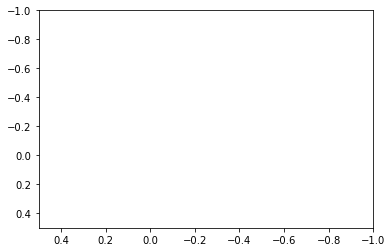

In [40]:
a = adjmatrix() 
pose = 0 #current
count = 0

for i in range(len(df)):
   
    e  = df.iloc[i]
    if e.Type == 'Pose':
        if pose > count-1:
            break
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
        pose = pose+1
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
      
a.graph_posegraph([],0)

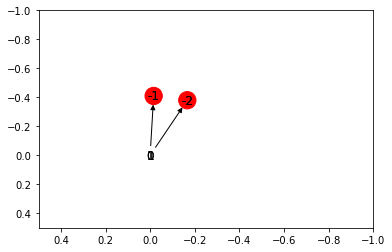

In [41]:
a = adjmatrix() 
pose = 0 #current
count = 1

for i in range(len(df)):
   
    e  = df.iloc[i]
    if e.Type == 'Pose':
        if pose > count-1:
            break
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
        pose = pose+1
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
      
a.graph_posegraph([],0)

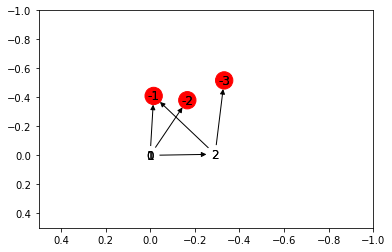

In [42]:
a = adjmatrix() 
pose = 0 #current
count = 2

for i in range(len(df)):
   
    e  = df.iloc[i]
    if e.Type == 'Pose':
        if pose > count-1:
            break
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
        pose = pose+1
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
      
a.graph_posegraph([],0)

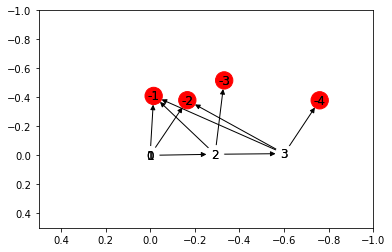

In [43]:
a = adjmatrix() 
pose = 0 #current
count = 3

for i in range(len(df)):
   
    e  = df.iloc[i]
    if e.Type == 'Pose':
        if pose > count-1:
            break
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
        pose = pose+1
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
      
a.graph_posegraph([],0)

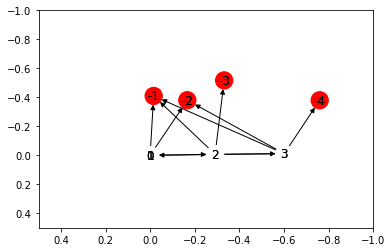

In [55]:
a = adjmatrix() 
for i in range(10):
   
    e  = pdf.iloc[i]
    if e.Type == 'Pose':
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
        pose = pose+1
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

e = pdf.iloc[11]
a.poseloopclosure(e.x,e.y,e.o,e.z, 1)
e = pdf.iloc[12]
a.posetooldfeat(e.x,e.y,e.o,e.z,-2)
a.graph_posegraph([],0)

In [48]:
a = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        a.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            a.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            a.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

# Visualize Gradient Descent

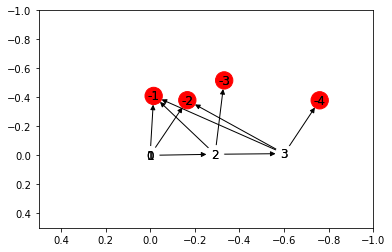

In [47]:
a.graph_posegraph([],0)

In [6]:
#a.nodedata[np.where(a.node>0)

# Visualize Gradient Descent

In [7]:
import os
import glob

#Clear 
files = glob.glob('pose/*')
for f in files:
    os.remove(f)

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 1, 3, 2, 1, 1, 1, 1]
out [1, 3, 0, 0, 3, 0, 3, 0]
factor [-2, -4, 6, 4, -4, 2, -4, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.1

<ipython-input-2-b0ddefa454b1>:176: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if nodedata == []:


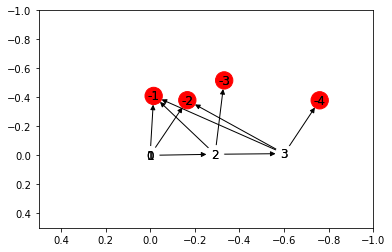

curcost 0.4121439718276593

1
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.43269730e-04 -1.92060000e-05 -3.44915010e-04 -9.99990000e+04]
 [-1.58461404e-02 -4.15680840e-01 -9.99990003e+04 -1.02998839e+05]
 [-1.68061294e-01 -3.83831216e-01 -9.99990003e+04 -1.01998840e+05]
 [-2.88020433e-01 -7.26478929e-03  2.22723080e-01 -1.99998000e+05]
 [-3.33222647e-01 -5.19336205e-01 -9.99987750e+04 -2.01997807e+05]
 [-5.94661982e-01 -1.15180946e-02  3.21120853e-01 -2.99997000e+05]
 [-7.63261176e-01 -3.81504727e-01 -9.99986756e+04 -3.02997113e+05]]


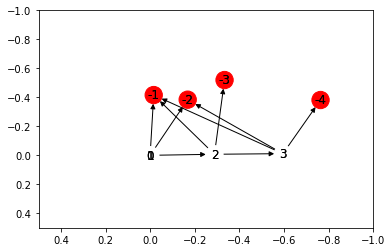

curcost 0.40314953824528604

2
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.40837033e-04 -1.90139400e-05 -3.41465860e-04 -9.99990000e+04]
 [-1.60838325e-02 -4.21916052e-01 -9.99990003e+04 -1.06088804e+05]
 [-1.69741907e-01 -3.87669528e-01 -9.99990003e+04 -1.04038817e+05]
 [-2.85140228e-01 -7.19214140e-03  2.20495849e-01 -1.99998000e+05]
 [-3.34888760e-01 -5.21932886e-01 -9.99987750e+04 -2.04017785e+05]
 [-5.88715362e-01 -1.14029137e-02  3.17909644e-01 -2.99997000e+05]
 [-7.67077482e-01 -3.83412251e-01 -9.99986756e+04 -3.06027085e+05]]


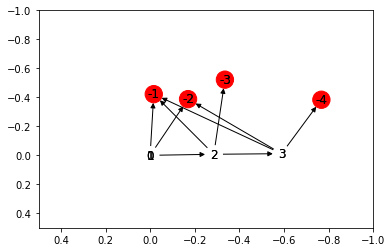

curcost 0.3945274949463571

3
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.38428662e-04 -1.88238006e-05 -3.38051201e-04 -9.99990000e+04]
 [-1.63250900e-02 -4.28244793e-01 -9.99990003e+04 -1.09271468e+05]
 [-1.71439326e-01 -3.91546224e-01 -9.99990003e+04 -1.06119593e+05]
 [-2.82288826e-01 -7.12021998e-03  2.18290891e-01 -1.99998000e+05]
 [-3.36563204e-01 -5.24542551e-01 -9.99987750e+04 -2.06057962e+05]
 [-5.82828209e-01 -1.12888845e-02  3.14730548e-01 -2.99997000e+05]
 [-7.70912870e-01 -3.85329312e-01 -9.99986756e+04 -3.09087355e+05]]


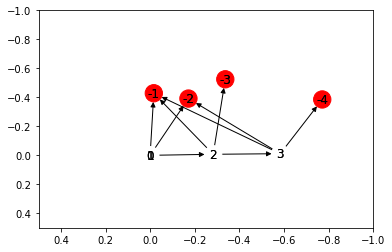

curcost 0.3862743950900071

4
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.36044376e-04 -1.86355626e-05 -3.34670689e-04 -9.99990000e+04]
 [-1.65699664e-02 -4.34668465e-01 -9.99990003e+04 -1.12549612e+05]
 [-1.73153719e-01 -3.95461686e-01 -9.99990003e+04 -1.08241985e+05]
 [-2.79465938e-01 -7.04901778e-03  2.16107982e-01 -1.99998000e+05]
 [-3.38246020e-01 -5.27165263e-01 -9.99987750e+04 -2.08118542e+05]
 [-5.76999927e-01 -1.11759957e-02  3.11583243e-01 -2.99997000e+05]
 [-7.74767434e-01 -3.87255959e-01 -9.99986756e+04 -3.12178229e+05]]


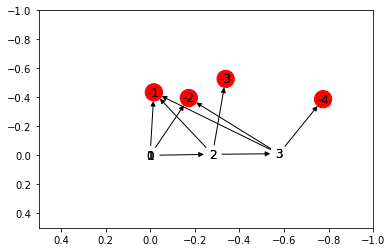

curcost 0.3783869069598979

5
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.33683932e-04 -1.84492070e-05 -3.31323982e-04 -9.99990000e+04]
 [-1.68185159e-02 -4.41188492e-01 -9.99990003e+04 -1.15926100e+05]
 [-1.74885257e-01 -3.99416303e-01 -9.99990003e+04 -1.10406825e+05]
 [-2.76671278e-01 -6.97852761e-03  2.13946902e-01 -1.99998000e+05]
 [-3.39937250e-01 -5.29801090e-01 -9.99987750e+04 -2.10199728e+05]
 [-5.71229928e-01 -1.10642357e-02  3.08467410e-01 -2.99997000e+05]
 [-7.78641271e-01 -3.89192239e-01 -9.99986756e+04 -3.15300011e+05]]


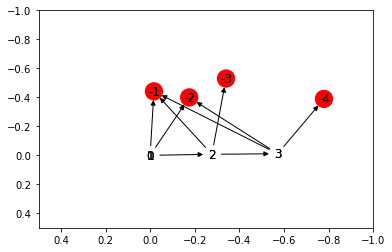

curcost 0.37086182344647667

6
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.31347093e-04 -1.82647149e-05 -3.28010743e-04 -9.99990000e+04]
 [-1.70707936e-02 -4.47806319e-01 -9.99990003e+04 -1.19403883e+05]
 [-1.76634109e-01 -4.03410466e-01 -9.99990003e+04 -1.12614962e+05]
 [-2.73904566e-01 -6.90874233e-03  2.11807433e-01 -1.99998000e+05]
 [-3.41636937e-01 -5.32450095e-01 -9.99987750e+04 -2.12301725e+05]
 [-5.65517628e-01 -1.09535934e-02  3.05382736e-01 -2.99997000e+05]
 [-7.82534477e-01 -3.91138200e-01 -9.99986756e+04 -3.18453011e+05]]


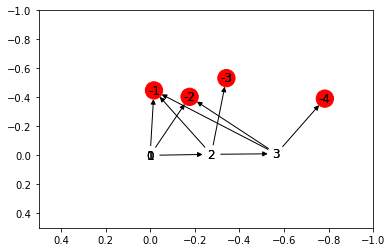

curcost 0.3636960750029026

7
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.29033622e-04 -1.80820677e-05 -3.24730635e-04 -9.99990000e+04]
 [-1.73268555e-02 -4.54523414e-01 -9.99990003e+04 -1.22986000e+05]
 [-1.78400450e-01 -4.07444570e-01 -9.99990003e+04 -1.14867261e+05]
 [-2.71165520e-01 -6.83965491e-03  2.09689359e-01 -1.99998000e+05]
 [-3.43345121e-01 -5.35112346e-01 -9.99987750e+04 -2.14424742e+05]
 [-5.59862452e-01 -1.08440574e-02  3.02328909e-01 -2.99997000e+05]
 [-7.86447150e-01 -3.93093891e-01 -9.99986756e+04 -3.21637541e+05]]


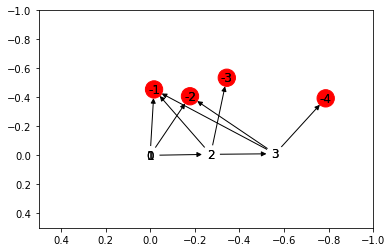

curcost 0.3568867465926033

8
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.26743286e-04 -1.79012471e-05 -3.21483329e-04 -9.99990000e+04]
 [-1.75867583e-02 -4.61341265e-01 -9.99990003e+04 -1.26675580e+05]
 [-1.80184455e-01 -4.11519016e-01 -9.99990003e+04 -1.17164606e+05]
 [-2.68453865e-01 -6.77125836e-03  2.07592465e-01 -1.99998000e+05]
 [-3.45061847e-01 -5.37787907e-01 -9.99987750e+04 -2.16568989e+05]
 [-5.54263827e-01 -1.07356169e-02  2.99305620e-01 -2.99997000e+05]
 [-7.90379386e-01 -3.95059360e-01 -9.99986756e+04 -3.24853917e+05]]


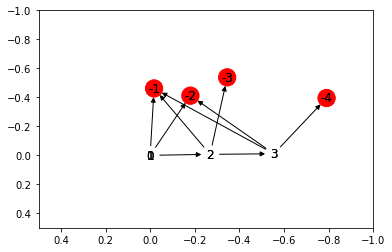

curcost 0.35043109921090254

9
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.24475853e-04 -1.77222346e-05 -3.18268496e-04 -9.99990000e+04]
 [-1.78505597e-02 -4.68261384e-01 -9.99990003e+04 -1.30475847e+05]
 [-1.81986299e-01 -4.15634206e-01 -9.99990003e+04 -1.19507898e+05]
 [-2.65769326e-01 -6.70354577e-03  2.05516540e-01 -1.99998000e+05]
 [-3.46787156e-01 -5.40476847e-01 -9.99987750e+04 -2.18734679e+05]
 [-5.48721189e-01 -1.06282607e-02  2.96312563e-01 -2.99997000e+05]
 [-7.94331283e-01 -3.97034657e-01 -9.99986756e+04 -3.28102456e+05]]


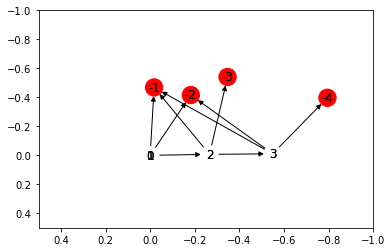

curcost 0.3443265966397114

10
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.22231094e-04 -1.75450123e-05 -3.15085811e-04 -9.99990000e+04]
 [-1.81183181e-02 -4.75285305e-01 -9.99990003e+04 -1.34390123e+05]
 [-1.83806162e-01 -4.19790548e-01 -9.99990003e+04 -1.21898056e+05]
 [-2.63111633e-01 -6.63651032e-03  2.03461375e-01 -1.99998000e+05]
 [-3.48521092e-01 -5.43179231e-01 -9.99987750e+04 -2.20922026e+05]
 [-5.43233977e-01 -1.05219781e-02  2.93349438e-01 -2.99997000e+05]
 [-7.98302939e-01 -3.99019830e-01 -9.99986756e+04 -3.31383481e+05]]


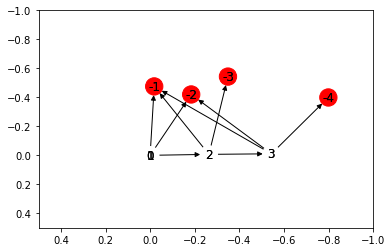

curcost 0.33857093818559625

11
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.20008783e-04 -1.73695621e-05 -3.11934952e-04 -9.99990000e+04]
 [-1.83900929e-02 -4.82414585e-01 -9.99990003e+04 -1.38421826e+05]
 [-1.85644224e-01 -4.23988454e-01 -9.99990003e+04 -1.24336017e+05]
 [-2.60480517e-01 -6.57014521e-03  2.01426761e-01 -1.99998000e+05]
 [-3.50263697e-01 -5.45895127e-01 -9.99987750e+04 -2.23131246e+05]
 [-5.37801637e-01 -1.04167583e-02  2.90415943e-01 -2.99997000e+05]
 [-8.02294454e-01 -4.01014930e-01 -9.99986756e+04 -3.34697315e+05]]


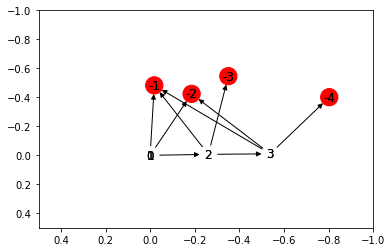

curcost 0.33316209826039017

12
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.17808695e-04 -1.71958665e-05 -3.08815603e-04 -9.99990000e+04]
 [-1.86659443e-02 -4.89650803e-01 -9.99990003e+04 -1.42574481e+05]
 [-1.87500666e-01 -4.28228338e-01 -9.99990003e+04 -1.26822738e+05]
 [-2.57875711e-01 -6.50444376e-03  1.99412494e-01 -1.99998000e+05]
 [-3.52015016e-01 -5.48624603e-01 -9.99987750e+04 -2.25362559e+05]
 [-5.32423621e-01 -1.03125907e-02  2.87511784e-01 -2.99997000e+05]
 [-8.06305926e-01 -4.03020004e-01 -9.99986756e+04 -3.38044289e+05]]


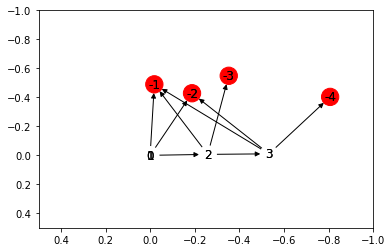

curcost 0.3280983737923432

13
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.15630608e-04 -1.70239078e-05 -3.05727447e-04 -9.99990000e+04]
 [-1.89459334e-02 -4.96995565e-01 -9.99990003e+04 -1.46851716e+05]
 [-1.89375673e-01 -4.32510622e-01 -9.99990003e+04 -1.29359192e+05]
 [-2.55296954e-01 -6.43939932e-03  1.97418369e-01 -1.99998000e+05]
 [-3.53775091e-01 -5.51367726e-01 -9.99987750e+04 -2.27616184e+05]
 [-5.27099385e-01 -1.02094648e-02  2.84636666e-01 -2.99997000e+05]
 [-8.10337456e-01 -4.05035104e-01 -9.99986756e+04 -3.41424731e+05]]


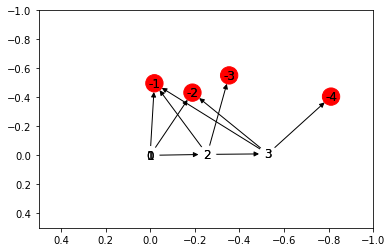

curcost 0.32337844060620385

14
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.13474302e-04 -1.68536688e-05 -3.02670172e-04 -9.99990000e+04]
 [-1.92301224e-02 -5.04450499e-01 -9.99990003e+04 -1.51257267e+05]
 [-1.91269430e-01 -4.36835728e-01 -9.99990003e+04 -1.31946376e+05]
 [-2.52743985e-01 -6.37500533e-03  1.95444185e-01 -1.99998000e+05]
 [-3.55543966e-01 -5.54124565e-01 -9.99987750e+04 -2.29892346e+05]
 [-5.21828391e-01 -1.01073702e-02  2.81790299e-01 -2.99997000e+05]
 [-8.14389143e-01 -4.07060280e-01 -9.99986756e+04 -3.44838979e+05]]


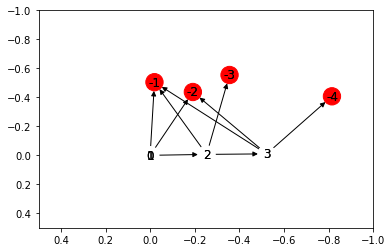

curcost 0.319001420082359

15
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.11339559e-04 -1.66851321e-05 -2.99643471e-04 -9.99990000e+04]
 [-1.95185743e-02 -5.12017256e-01 -9.99990003e+04 -1.55794985e+05]
 [-1.93182124e-01 -4.41204085e-01 -9.99990003e+04 -1.34585304e+05]
 [-2.50216545e-01 -6.31125528e-03  1.93489743e-01 -1.99998000e+05]
 [-3.57321686e-01 -5.56895187e-01 -9.99987750e+04 -2.32191270e+05]
 [-5.16610107e-01 -1.00062965e-02  2.78972396e-01 -2.99997000e+05]
 [-8.18461089e-01 -4.09095581e-01 -9.99986756e+04 -3.48287369e+05]]


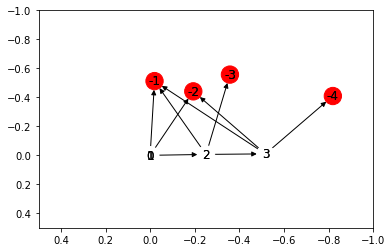

curcost 0.31496695759474685

16
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.09226164e-04 -1.65182808e-05 -2.96647036e-04 -9.99990000e+04]
 [-1.98113529e-02 -5.19697515e-01 -9.99990003e+04 -1.60468835e+05]
 [-1.95113945e-01 -4.45616126e-01 -9.99990003e+04 -1.37277010e+05]
 [-2.47714379e-01 -6.24814272e-03  1.91554846e-01 -1.99998000e+05]
 [-3.59108295e-01 -5.59679663e-01 -9.99987750e+04 -2.34513182e+05]
 [-5.11444006e-01 -9.90623350e-03  2.76182672e-01 -2.99997000e+05]
 [-8.22553394e-01 -4.11141059e-01 -9.99986756e+04 -3.51770242e+05]]


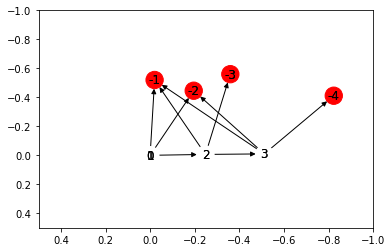

curcost 0.3112753144256865

17
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.07133902e-04 -1.63530980e-05 -2.93680566e-04 -9.99990000e+04]
 [-2.01085232e-02 -5.27492978e-01 -9.99990003e+04 -1.65282900e+05]
 [-1.97065085e-01 -4.50072287e-01 -9.99990003e+04 -1.40022550e+05]
 [-2.45237236e-01 -6.18566130e-03  1.89639297e-01 -1.99998000e+05]
 [-3.60903836e-01 -5.62478062e-01 -9.99987750e+04 -2.36858314e+05]
 [-5.06329566e-01 -9.80717116e-03  2.73420846e-01 -2.99997000e+05]
 [-8.26666161e-01 -4.13196764e-01 -9.99986756e+04 -3.55287945e+05]]


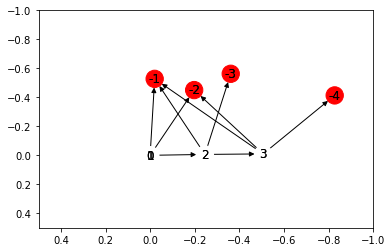

curcost 0.3079274750451051

18
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.05062563e-04 -1.61895670e-05 -2.90743760e-04 -9.99990000e+04]
 [-2.04101510e-02 -5.35405373e-01 -9.99990003e+04 -1.70241387e+05]
 [-1.99035735e-01 -4.54573010e-01 -9.99990003e+04 -1.42823001e+05]
 [-2.42784863e-01 -6.12380468e-03  1.87742904e-01 -1.99998000e+05]
 [-3.62708355e-01 -5.65290452e-01 -9.99987750e+04 -2.39226897e+05]
 [-5.01266270e-01 -9.70909945e-03  2.70686637e-01 -2.99997000e+05]
 [-8.30799492e-01 -4.15262748e-01 -9.99986756e+04 -3.58840824e+05]]


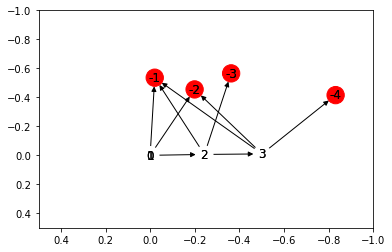

curcost 0.3049252717900534

19
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.03011937e-04 -1.60276713e-05 -2.87836322e-04 -9.99990000e+04]
 [-2.07163033e-02 -5.43436453e-01 -9.99990003e+04 -1.75348628e+05]
 [-2.01026093e-01 -4.59118740e-01 -9.99990003e+04 -1.45679461e+05]
 [-2.40357015e-01 -6.06256664e-03  1.85865475e-01 -1.99998000e+05]
 [-3.64521897e-01 -5.68116904e-01 -9.99987750e+04 -2.41619166e+05]
 [-4.96253608e-01 -9.61200846e-03  2.67979771e-01 -2.99997000e+05]
 [-8.34953489e-01 -4.17339062e-01 -9.99986756e+04 -3.62429232e+05]]


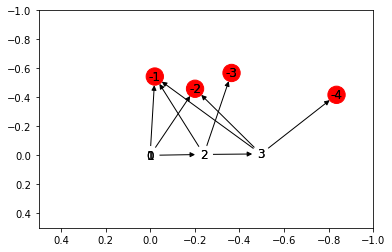

curcost 0.30227152903513854

20
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.00981818e-04 -1.58673946e-05 -2.84957959e-04 -9.99990000e+04]
 [-2.10270478e-02 -5.51588000e-01 -9.99990003e+04 -1.80609087e+05]
 [-2.03036354e-01 -4.63709928e-01 -9.99990003e+04 -1.48593050e+05]
 [-2.37953445e-01 -6.00194097e-03  1.84006820e-01 -1.99998000e+05]
 [-3.66344506e-01 -5.70957489e-01 -9.99987750e+04 -2.44035358e+05]
 [-4.91291072e-01 -9.51588837e-03  2.65299973e-01 -2.99997000e+05]
 [-8.39128257e-01 -4.19425757e-01 -9.99986756e+04 -3.66053525e+05]]


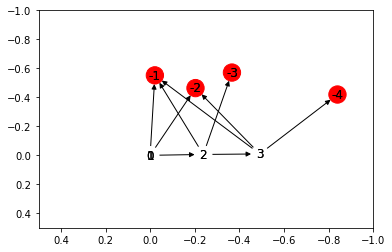

curcost 0.2999702288225057

21
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.98972000e-04 -1.57087206e-05 -2.82108380e-04 -9.99990000e+04]
 [-2.13424536e-02 -5.59861820e-01 -9.99990003e+04 -1.86027360e+05]
 [-2.05066717e-01 -4.68347027e-01 -9.99990003e+04 -1.51564911e+05]
 [-2.35573910e-01 -5.94192156e-03  1.82166752e-01 -1.99998000e+05]
 [-3.68176229e-01 -5.73812276e-01 -9.99987750e+04 -2.46475712e+05]
 [-4.86378161e-01 -9.42072949e-03  2.62646973e-01 -2.99997000e+05]
 [-8.43323898e-01 -4.21522886e-01 -9.99986756e+04 -3.69714060e+05]]


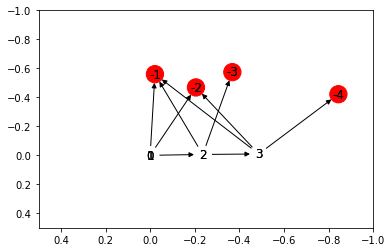

curcost 0.29802669949651006

22
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.96982280e-04 -1.55516334e-05 -2.79287296e-04 -9.99990000e+04]
 [-2.16625904e-02 -5.68259747e-01 -9.99990003e+04 -1.91608181e+05]
 [-2.07117384e-01 -4.73030497e-01 -9.99990003e+04 -1.54596209e+05]
 [-2.33218171e-01 -5.88250234e-03  1.80345085e-01 -1.99998000e+05]
 [-3.70017110e-01 -5.76681338e-01 -9.99987750e+04 -2.48940469e+05]
 [-4.81514379e-01 -9.32652219e-03  2.60020504e-01 -2.99997000e+05]
 [-8.47540517e-01 -4.23630500e-01 -9.99986756e+04 -3.73411201e+05]]


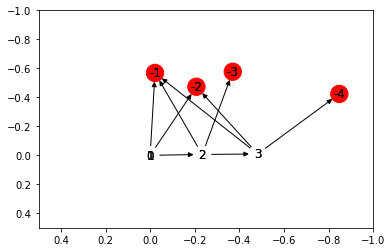

curcost 0.29644782798489416

23
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.95012457e-04 -1.53961171e-05 -2.76494423e-04 -9.99990000e+04]
 [-2.19875292e-02 -5.76783643e-01 -9.99990003e+04 -1.97356426e+05]
 [-2.09188558e-01 -4.77760802e-01 -9.99990003e+04 -1.57688134e+05]
 [-2.30885989e-01 -5.82367732e-03  1.78541634e-01 -1.99998000e+05]
 [-3.71867196e-01 -5.79564744e-01 -9.99987750e+04 -2.51429873e+05]
 [-4.76699235e-01 -9.23325697e-03  2.57420299e-01 -2.99997000e+05]
 [-8.51778220e-01 -4.25748653e-01 -9.99986756e+04 -3.77145313e+05]]


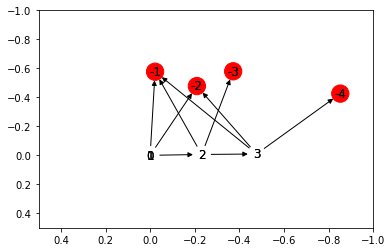

curcost 0.29524229474575076

24
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.93062333e-04 -1.52421559e-05 -2.73729479e-04 -9.99990000e+04]
 [-2.23173421e-02 -5.85435398e-01 -9.99990003e+04 -2.03277119e+05]
 [-2.11280444e-01 -4.82538410e-01 -9.99990003e+04 -1.60841896e+05]
 [-2.28577129e-01 -5.76544055e-03  1.76756218e-01 -1.99998000e+05]
 [-3.73726532e-01 -5.82462568e-01 -9.99987750e+04 -2.53944172e+05]
 [-4.71932243e-01 -9.14092440e-03  2.54846096e-01 -2.99997000e+05]
 [-8.56037111e-01 -4.27877396e-01 -9.99986756e+04 -3.80916766e+05]]


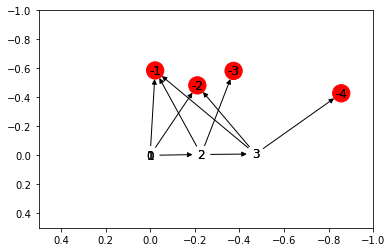

curcost 0.2944208277642468

25
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.91131709e-04 -1.50897344e-05 -2.70992184e-04 -9.99990000e+04]
 [-2.26521023e-02 -5.94216929e-01 -9.99990003e+04 -2.09375432e+05]
 [-2.13393248e-01 -4.87363794e-01 -9.99990003e+04 -1.64058734e+05]
 [-2.26291358e-01 -5.70778614e-03  1.74988655e-01 -1.99998000e+05]
 [-3.75595164e-01 -5.85374881e-01 -9.99987750e+04 -2.56483614e+05]
 [-4.67212921e-01 -9.04951516e-03  2.52297635e-01 -2.99997000e+05]
 [-8.60317297e-01 -4.30016783e-01 -9.99986756e+04 -3.84725933e+05]]


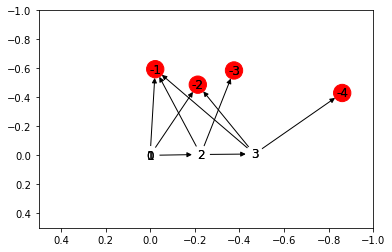

curcost 0.293996468026633

26
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.89220392e-04 -1.49388370e-05 -2.68282262e-04 -9.99990000e+04]
 [-2.29918838e-02 -6.03130183e-01 -9.99990003e+04 -2.15656695e+05]
 [-2.15527181e-01 -4.92237432e-01 -9.99990003e+04 -1.67339909e+05]
 [-2.24028444e-01 -5.65070828e-03  1.73238769e-01 -1.99998000e+05]
 [-3.77473140e-01 -5.88301755e-01 -9.99987750e+04 -2.59048450e+05]
 [-4.62540791e-01 -8.95902001e-03  2.49774658e-01 -2.99997000e+05]
 [-8.64618883e-01 -4.32166867e-01 -9.99986756e+04 -3.88573193e+05]]


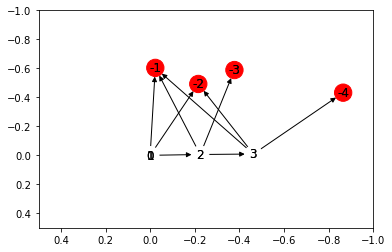

curcost 0.29398483339876463

27
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.87328188e-04 -1.47894487e-05 -2.65599439e-04 -9.99990000e+04]
 [-2.33367621e-02 -6.12177136e-01 -9.99990003e+04 -2.22126396e+05]
 [-2.17682453e-01 -4.97159806e-01 -9.99990003e+04 -1.70686707e+05]
 [-2.21788160e-01 -5.59420120e-03  1.71506381e-01 -1.99998000e+05]
 [-3.79360506e-01 -5.91243264e-01 -9.99987750e+04 -2.61638935e+05]
 [-4.57915384e-01 -8.86942981e-03  2.47276912e-01 -2.99997000e+05]
 [-8.68941978e-01 -4.34327701e-01 -9.99986756e+04 -3.92458925e+05]]


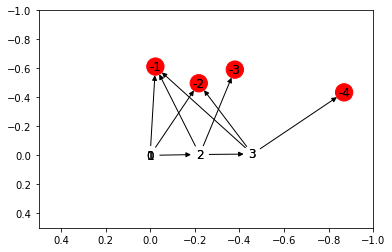

curcost 0.29440436085058513

converge
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 1.85454906e-04 -1.46415542e-05 -2.62943445e-04 -9.99990000e+04]
 [-2.36868135e-02 -6.21359793e-01 -9.99990003e+04 -2.28790188e+05]
 [-2.19859277e-01 -5.02131405e-01 -9.99990003e+04 -1.74100441e+05]
 [-2.19570278e-01 -5.53825919e-03  1.69791317e-01 -1.99998000e+05]
 [-3.81257308e-01 -5.94199480e-01 -9.99987750e+04 -2.64255324e+05]
 [-4.53336230e-01 -8.78073551e-03  2.44804143e-01 -2.99997000e+05]
 [-8.73286687e-01 -4.36499340e-01 -9.99986756e+04 -3.96383514e+05]]


In [8]:
a.gd(iterations = 100, learning_rate = 0.005, stopping_threshold = 0.1, posegraph = True) #Remember to Change

In [9]:
from os import listdir
from os.path import isfile, join
mypath = "pose"
onlyfiles = [f for f in listdir(mypath) if isfile(join(mypath, f))]
print("number of jpg: "+str(len(onlyfiles)))

number of jpg: 28


In [10]:
import imageio

with imageio.get_writer('optimization.gif', mode='I') as writer:
    for filename in list(range(0,len(onlyfiles))):
        image = imageio.imread("pose/"+str(filename)+".jpg")
        writer.append_data(image)
        
print("saved")

saved


# Convergence of Gradient Descent

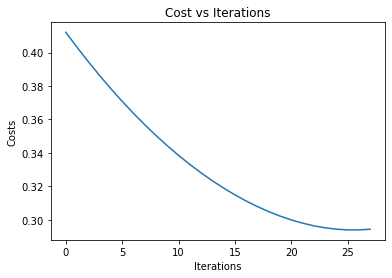

0.29440436085058513


In [11]:
a.prcost()

# Comparison of Accuracy

Optimized Estimate vs Initial vs Ground Truth

In [12]:
initial = a.nodedata[np.where(a.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
initialxy = []
#initialdiff = []
initialrote = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:3].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    initialrote.append(rot.round(decimals = 3) )
    #initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
optim = a.converge[np.where(a.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
optimxy = []
#optimdiff = []
optimrote = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:3].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i][0:2]
    rot = abs(optim[i][2]-groundtruth[i][2])
    optimrote.append(rot.round(decimals = 3) )
    #optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
compare = pd.DataFrame(list(zip(groundtruth, initialxy, initialrote, initialL2, optimxy, optimrote, optimL2)), columns = ('groundtruth', 'initialxy', 'initialrotE', 'initialL2', 'optimxy', 'optimrotE', 'optimL2'))

compare.to_csv("comparisonNORMAL.csv")
compare

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.22, -0.006, 0.17]",0.170,0.020
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.453, -0.009, 0.245]",0.245,0.054


# Testing Parameters (Learning Rate)

In [13]:
pdf = pd.read_csv("dataset/e3v4initialcoordsswap.csv")
df = pdf[0:10]


In [14]:
h = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        h.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            h.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            h.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

In [15]:
#Track Costs
LR = []
Costs = []
Ite = []

In [16]:
%%capture
learning = 0.0001
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [17]:
%%capture
learning = 0.0002
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [18]:
%%capture
learning = 0.0004
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [19]:
%%capture
learning = 0.0008
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [20]:
%%capture
learning = 0.0012
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [21]:
%%capture
learning = 0.0024
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [22]:
%%capture
learning = 0.0048
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [23]:
%%capture
learning = 0.0096
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [24]:
%%capture
learning = 0.0192
h.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False)
LR.append(learning)
Costs.append(h.prcost_n())
Ite.append(h.prcost_i())

In [25]:
lrdf = pd.DataFrame(list(zip(LR, Costs,Ite)), 
             columns = ('Learning Rate', 'Final Cost', 'Iterations'))

s1 = pd.Series(100)
s2 = s1.append(abs(lrdf.Iterations.diff(periods=-1)).drop([8]), ignore_index = True)
lrdf["Iterations"] = s2

lrdf.to_csv("learningrate.csv")
lrdf

,Learning Rate,Final Cost,Iterations
0,0.0001,0.403214,100.0
1,0.0002,0.386395,100.0
2,0.0004,0.357103,100.0
3,0.0008,0.315328,100.0
4,0.0012,0.295751,100.0
5,0.0024,0.294380,56.0
6,0.0048,0.294341,29.0
7,0.0096,0.294234,15.0
8,0.0192,0.295004,8.0


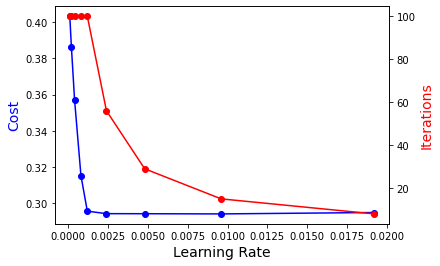

In [26]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(lrdf['Learning Rate'], lrdf['Final Cost'], color="blue", marker="o")
# set x-axis label
ax.set_xlabel("Learning Rate",fontsize=14)
# set y-axis label
ax.set_ylabel("Cost",color="blue",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(lrdf['Learning Rate'], lrdf["Iterations"],color="red",marker="o")
ax2.set_ylabel("Iterations",color="red",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('Cost vs Learning Rate.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')



# Testing Parameters (Weighting)

In [27]:
j = adjmatrix() 
for i in range(len(df)):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        j.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            j.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            j.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)

In [28]:
#Track Costs
Ratio = []
Trans = []
Rota = []
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
learning = 0.001

k = [0.35,0.30,0.25,0.20,0.15,0.10,0.05,0.01,0.001,0.005,0.001,0.0005,0.0001]

In [29]:
%%capture

R = k[0]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [30]:
%%capture

R = k[1]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [31]:
%%capture

R = k[2]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff) 
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [32]:
%%capture

R = k[3]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [33]:
%%capture

R = k[4]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff) 
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [34]:
%%capture

R = k[5]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [35]:
%%capture

R = k[6]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [36]:
%%capture

R = k[7]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [37]:
%%capture

R = k[8]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [38]:
%%capture

R = k[9]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [39]:
%%capture

R = k[10]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [40]:
%%capture

R = k[11]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [41]:
%%capture

R = k[12]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

In [42]:
%%capture

R = k[13]
j.setweight(R)
j.gd(iterations = 100, learning_rate = learning, stopping_threshold = 0.1, posegraph = False) 

initial = j.converge[np.where(j.node>0)] 
TransE = 0
RotaE = 0
for i in range(len(initial)):
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    TransE = TransE + np.linalg.norm(diff)
    RotaE = RotaE + rot.round(decimals = 3)
Ratio.append(float(R))
Trans.append(TransE)
Rota.append(RotaE)

IndexError: list index out of range

In [43]:
er = pd.DataFrame(list(zip(Ratio,Trans,Rota)), 
             columns = ('Weighting Ratio', 'Translational Error', 'Rotational Error'))

er.to_csv("WeightingRatio.csv")
er

,Weighting Ratio,Translational Error,Rotational Error
0,0.3500,0.176058,0.423
1,0.3000,0.191703,0.415
2,0.2500,0.207668,0.407
3,0.2000,0.223957,0.398
4,0.1500,0.240577,0.391
5,0.1000,0.267522,0.425
6,0.0500,0.290163,0.523
7,0.0100,0.292442,0.547
8,0.0010,0.292474,0.547
9,0.0050,0.292460,0.547


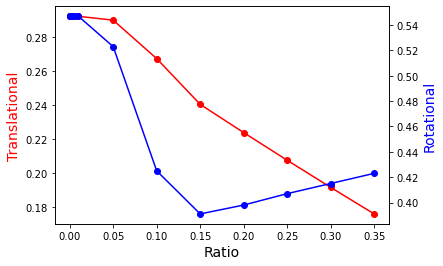

In [44]:
# create figure and axis objects with subplots()
fig,ax = plt.subplots()
# make a plot
ax.plot(er['Weighting Ratio'], er['Translational Error'], color="red", marker="o")
# set x-axis label
ax.set_xlabel("Ratio",fontsize=14)
# set y-axis label
ax.set_ylabel("Translational",color="red",fontsize=14)

ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(er['Weighting Ratio'], er["Rotational Error"],color="blue",marker="o")
ax2.set_ylabel("Rotational",color="blue",fontsize=14)
plt.show()
# save the plot as a file
fig.savefig('Error vs Ratio.jpg',
            format='jpeg',
            dpi=100,
            bbox_inches='tight')

# Comparisons

GT vs Intial vs Optimal

C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


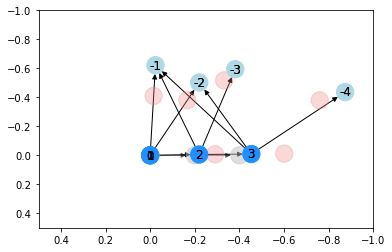

In [45]:

#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal vs GT.jpg")

Intial vs Optimal

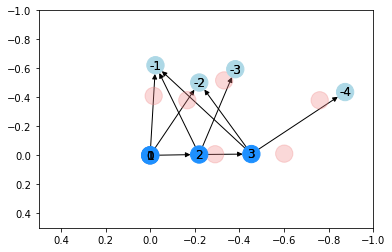

In [46]:
#-----------------------------

#Initial
nodedata = a.nodedata

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightcoral')
    else: 
        color_map.append('lightcoral')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.3, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('dodgerblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("Intial vs Optimal.jpg")

# Test Loop Closure

In [47]:
#df = df[0:10]
df = pdf
df

,Type,Match,Node,x,y,o,z
0,Pose,NaN,1,0.000246,-0.000019,-0.000348,-99999.000000
1,Feat,NaN,-1,-0.015858,-0.409518,-99999.000000,0.127412
2,Feat,NaN,-2,-0.166643,-0.380012,-99999.000000,0.136918
3,Pose,NaN,2,-0.291175,-0.007319,0.225321,-99999.000000
4,Feat,-1.0,-1,-0.039523,-0.507076,-99999.000000,0.169411
5,Feat,NaN,-3,-0.040635,-0.509414,-99999.000000,0.171712
6,Pose,NaN,3,-0.309739,-0.004296,0.099392,-99999.000000
7,Feat,-2.0,-2,-0.159924,-0.368080,-99999.000000,-0.143533
8,Feat,NaN,-4,-0.158795,-0.367972,-99999.000000,-0.142006
9,Feat,-1.0,-1,-0.039531,-0.495899,-99999.000000,0.174748


In [48]:
loop = adjmatrix() 
for i in range(11):
    e  = df.iloc[i]
    if e.Type == 'Pose':
        loop.posetopose(e.x,e.y,e.o,e.z) #new pose x,y,o,{z}
    else:
        if pd.isna(e.Match):
            #add new feat
            loop.posetonewfeat(e.x,e.y,e.o,e.z)
        else:
            #old feat, link
            loop.posetooldfeat(e.x,e.y,e.o,e.z,e.Match)
            
e = df.iloc[11]
loop.poseloopclosure(e.x,e.y,e.o,e.z, 1)
e = df.iloc[12]
loop.posetooldfeat(e.x,e.y,e.o,e.z,-2)

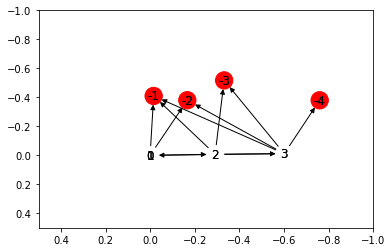

In [49]:
loop.graph_posegraph([],0)

In [50]:
loop.gd(iterations = 1000, learning_rate = 0.001, stopping_threshold = 0.1, posegraph = False) #Remember to Change

original
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.16752443e-01 -9.99987750e+04 -1.99997828e+05]
 [-6.00668669e-01 -1.16344390e-02  3.24364498e-01 -2.99997000e+05]
 [-7.59463857e-01 -3.79606694e-01 -9.99986756e+04 -2.99997142e+05]]
in [0, 2, 3, 2, 1, 2, 1, 1]
out [1, 3, 0, 0, 3, 0, 5, 0]
factor [-2, -2, 6, 4, -4, 4, -8, 2]


0
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 2.45727000e-04 -1.94000000e-05 -3.48399000e-04 -9.99990000e+04]
 [-1.56119610e-02 -4.09537773e-01 -9.99990003e+04 -9.99988726e+04]
 [-1.66397321e-01 -3.80030907e-01 -9.99990003e+04 -9.99988631e+04]
 [-2.90929730e-01 -7.33817100e-03  2.24972808e-01 -1.99998000e+05]
 [-3.31564823e-01 -5.1

In [51]:
initial = loop.nodedata[np.where(loop.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
initialxy = []
#initialdiff = []
initialrote = []
initialL2 = []

for i in range(len(initial)):
    initialxy.append(initial[i][0:3].round(decimals = 3) )
    diff = initial[i][0:2]-groundtruth[i][0:2]
    rot = abs(initial[i][2]-groundtruth[i][2])
    initialrote.append(rot.round(decimals = 3) )
    #initialdiff.append(diff.round(decimals = 3) )
    initialL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
optim = loop.converge[np.where(loop.node>0)] 
groundtruth = np.array([[0,0,0],[-0.2,0,0],[-0.4,0,0],[0,0,0]])
optimxy = []
#optimdiff = []
optimrote = []
optimL2 = []

for i in range(len(optim)):
    optimxy.append(optim[i][0:3].round(decimals = 3) )
    diff = optim[i][0:2]-groundtruth[i][0:2]
    rot = abs(optim[i][2]-groundtruth[i][2])
    optimrote.append(rot.round(decimals = 3) )
    #optimdiff.append(diff.round(decimals = 3) )
    optimL2.append(np.linalg.norm(diff).round(decimals = 3) )
    
compare_lc = pd.DataFrame(list(zip(groundtruth, initialxy, initialrote, initialL2, optimxy, optimrote, optimL2)), columns = ('groundtruth', 'initialxy', 'initialrotE', 'initialL2', 'optimxy', 'optimrotE', 'optimL2'))

compare_lc.to_csv("comparisonLOOPCL.csv")
compare_lc

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.245, -0.006, 0.189]",0.189,0.045
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.426, -0.008, 0.23]",0.230,0.027


ABOVE (WITH LOOP CLOSURE)

BELOW (WITHOUT LOOP CLOSURE)

In [52]:
compare

,groundtruth,initialxy,initialrotE,initialL2,optimxy,optimrotE,optimL2
0,"[0.0, 0.0, 0.0]","[0.0, -0.0, -0.0]",0.000,0.000,"[0.0, -0.0, -0.0]",0.000,0.000
1,"[-0.2, 0.0, 0.0]","[-0.291, -0.007, 0.225]",0.225,0.091,"[-0.22, -0.006, 0.17]",0.170,0.020
2,"[-0.4, 0.0, 0.0]","[-0.601, -0.012, 0.324]",0.324,0.201,"[-0.453, -0.009, 0.245]",0.245,0.054


C:\Users\User\anaconda3\lib\site-packages\matplotlib\patches.py:2993: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


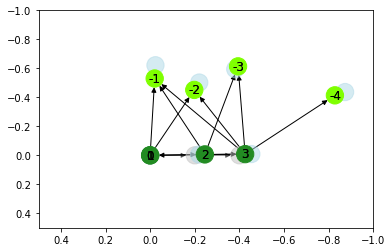

In [53]:
#Ground Truth
b = adjmatrix() 
b.posetopose(0,0,0,0) #
b.posetopose(-0.2,0,0,0) #
b.posetopose(-0.2,0,0,0) #
#b.posetopose(0,0,0,0) #
nodedata = b.nodedata

amat = b.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, b.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('red')
    else: 
        color_map.append('silver')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(b.node, ps)
dic = dict(z)

fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, node_size = 300,with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)


#-----------------------------

#Optimal without Loop Closure
nodedata = a.converge

amat = a.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, a.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('lightblue')
    else: 
        color_map.append('lightblue')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(a.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, alpha = 0.5, width = 0, arrowsize = 0, with_labels = False)
#nx.draw_networkx_labels(g, pos=dic)

#-----------------------------

#Optimal with Loop Closure
nodedata = loop.converge

amat = loop.matrix
g = nx.from_numpy_matrix(amat, create_using=nx.DiGraph)
g.remove_nodes_from(list(nx.isolates(g)))

#relabelling
mapping = dict(zip(g, loop.node))
g = nx.relabel_nodes(g, mapping)

#colourmap
color_map = []
for node in g.nodes:
    if node < 0:
        color_map.append('chartreuse')
    else: 
        color_map.append('forestgreen')      

#layout
layout = nx.spectral_layout(g)
#layout = nx.spring_layout(g)

#position
position = copy.deepcopy(nodedata)
ps = []
for pos in position:
    ps.append(pos[:2])

z = zip(loop.node, ps)
dic = dict(z)

#fig, ax = plt.subplots()

nx.draw_networkx(g, pos=dic, node_color = color_map, with_labels = True)
nx.draw_networkx_labels(g, pos=dic)

#-----------------------------


plt.axis("on")
ax.set_xlim(0.5, -1)
ax.set_ylim(0.5, -1)

ax.tick_params(left=True, bottom=True, labelleft=True, labelbottom=True)

plt.savefig("LoopClosure vs NonLoopClosure.jpg")